In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
import os.path as path
from scipy import misc
from keras.utils import np_utils
from keras.models import Sequential, Model,load_model
from keras.layers import Input,Layer,concatenate,Reshape
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from datetime import datetime 
import matplotlib.pyplot as plt
from PIL import Image
import json
import keras
from keras import backend as K
from keras.applications.xception import preprocess_input
from keras import models
from keras.preprocessing.image import img_to_array
from keras.layers.core import Activation,Dense,Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
train_df=pd.read_csv("../input/severstal-steel-defect-detection/train.csv")
train_df['ImageId']=train_df['ImageId_ClassId'].apply(lambda x:x.split('_')[0])
train_df['ClassId']=train_df['ImageId_ClassId'].apply(lambda x:x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [3]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [4]:
sub_df = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [5]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

In [6]:
def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
            
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img
        
        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty(( self.batch_size, *self.dim, self.n_classes), dtype=int)
    
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
                
        return y
            
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img,axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [8]:
BATCH_SIZE = 8

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [10]:
def build_model(input_shape):
    inputs = Input(input_shape)
    
    c1 = Conv2D(16, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (inputs)
    c1 = Conv2D(16, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c1)
    c1 = Dense(16,activation='relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (p1)
    c2 = Conv2D(32, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c2)
    c2 = Dense(32,activation='relu')(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (p2)
    c3 = Conv2D(64, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c3)
    c3 = Dense(64,activation='relu')(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (p3)
    c4 = Conv2D(128, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c4)
    c4 = Dense(128,activation='relu')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (p4)
    c5 = Dense(256,activation='relu')(c5)
    c5=BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c5)
    c5 = Dense(256,activation='relu')(c5)
    c5=BatchNormalization()(c5)
    
    u6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (u6)
    c6 = Dense(128,activation='relu')(c6)
    c6 = Conv2D(128, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c6)

    u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (u7)
    c7 = Dense(64,activation='relu')(c7)
    c7 = Conv2D(64, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (u8)
    c8 = Dense(32,activation='relu')(c8)
    c8 = Conv2D(32, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (u9)
    c9 = Dense(16,activation='relu')(c9)
    c9 = Conv2D(16, (3, 3), padding='same',dilation_rate=(2,2),activation='relu') (c9)

    outputs = Conv2D(4, (1, 1), activation='softmax') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [11]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 16 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 16 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256, 1600, 16 272         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [12]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=4
)


Epoch 1/4
1335/1335 [==============================] - 867s 649ms/step - loss: 0.2951 - dice_coef: 0.0193 - val_loss: 0.2915 - val_dice_coef: 0.0178
Epoch 2/4
1335/1335 [==============================] - 853s 639ms/step - loss: 0.2939 - dice_coef: 0.0228 - val_loss: 0.2908 - val_dice_coef: 0.0229
Epoch 3/4
1335/1335 [==============================] - 816s 611ms/step - loss: 0.2926 - dice_coef: 0.0265 - val_loss: 0.2912 - val_dice_coef: 0.0232
Epoch 4/4
1335/1335 [==============================] - 822s 615ms/step - loss: 0.2918 - dice_coef: 0.0288 - val_loss: 0.2929 - val_dice_coef: 0.0307


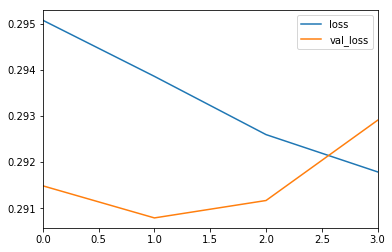

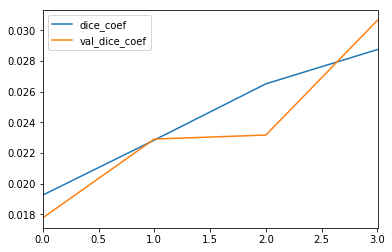

In [13]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [14]:
model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

500/500 [==============================] - 16s 32ms/step


500it [00:06, 77.71it/s]

  1/500 [..............................] - ETA: 21s

500/500 [==============================] - 15s 30ms/step


500it [00:06, 77.26it/s]


500/500 [==============================] - 15s 30ms/step


500it [00:06, 76.44it/s]


301/301 [==============================] - 9s 30ms/step


301it [00:04, 74.05it/s]


In [15]:
test1_df = pd.concat(test_df)

In [16]:
test1_df.iloc[7100:7115]

,ImageId_ClassId,EncodedPixels,ImageId
7100,fc9af41b0.jpg_1,,fc9af41b0.jpg
7101,fc9af41b0.jpg_2,,fc9af41b0.jpg
7102,fc9af41b0.jpg_3,1669 1 1671 1 1673 1 1675 1 1927 1 1929 1 1931...,fc9af41b0.jpg
7103,fc9af41b0.jpg_4,,fc9af41b0.jpg
7104,fc9b9483f.jpg_1,,fc9b9483f.jpg
7105,fc9b9483f.jpg_2,,fc9b9483f.jpg
7106,fc9b9483f.jpg_3,38681 1 38683 1 38688 1 38690 1 39451 1 39453 ...,fc9b9483f.jpg
7107,fc9b9483f.jpg_4,,fc9b9483f.jpg
7108,fca5873cd.jpg_1,,fca5873cd.jpg
7109,fca5873cd.jpg_2,,fca5873cd.jpg


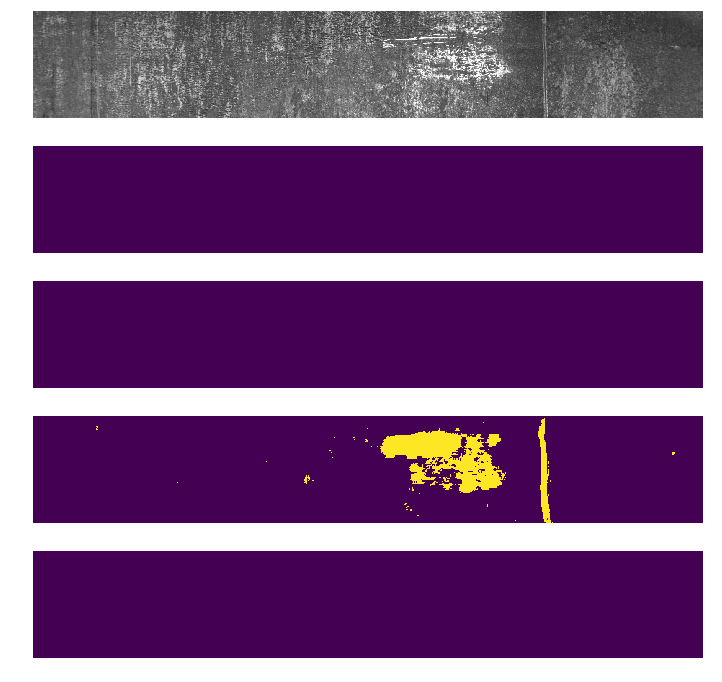

In [17]:
sample_filename = 'fc9b9483f.jpg'
sample_image_df = test1_df[test1_df['ImageId'] == sample_filename]
sample_path = f"../input/severstal-steel-defect-detection/test_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

In [18]:
test1_df.drop(columns='ImageId', inplace=True)
test1_df.to_csv('submission.csv', index=False)